# d'Alembert with computer algebra system

##  d'Alembert principle



<img align="right" width="150px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Alembert.jpg/440px-Alembert.jpg"  />

**d'Alembert**  principle states that the sum of the differences between the forces acting on a system of mass particles and the time derivatives of the momenta of the system itself projected onto any virtual displacement consistent with the constraints of the system is zero.

It can be  written as following,

$$\sum_{i} ( \mathbf {F}_{i} - m_i \mathbf{\ddot x}_i )\cdot \delta \mathbf r_i = 0,\label{eq:dalem}\tag{1}$$ 

where:

 - $i$ enumerates particles,
 - $\mathbf{F_i}$ $\mathbf{\ddot x_i}$ are forces and accelerations of $i$-th particle,
 - $\delta \mathbf r_i$ is virtual displacement of $i$-th particle.

We consider $N$ particles in $3$ dimensional physical space, subjected to   $p$ holonomous constraints in the form:
$$ f_k(x, t) = 0\quad k=1,2,...,p. $$


The virtual displacements of each coordinates: $\delta x_j$, can be arbitrary numbers fulfilling: 

$$\sum_{j=1}^{3N} \frac{\partial f_k}{\partial x_j} \delta x_j=0,\quad k=1,2,...,p. \label{eq:constr}\tag{2}$$   

This is a homogenoues system of  $p$ linear equation for  $3N$ $\delta x_j$, thus  $p$ displacements can be expressed by remaining $3N-p$ which are arbitrary.

We can substitute this solution to the original d'Alembert equation $\eqref{eq:dalem}$  and we will obtain $3N-p$ second order differential equations. Together with $p$ constraints $\eqref{eq:constr}$  they can allow to determine evolution of all variables. Let us note that this is system of differential-algebraic equations. It can be solved for example by differentiating algebraic equations and solvin the system od ODEs in classical manner.


Better possibility, used in most of texbook problems, is to find equation of motion in $3N-p$ independent generalized coordinates which are compliant with the constraints. Then we need to transform d'Alembert principle $\eqref{eq:dalem}$ into those coordinates and it  leads to a system of $3N-p$ ODEs.

## How to use CAS with d'Alembert principle.

One of the problems which prohibit direct use of CAS is the need to treat symbols as independent variables and as functions of time, depending on the context. One possible solution to this is to define for each symbolic variable the correspoding  Sage symbolic function and variables which would represent first and second derivative.

 - coordinate - small letter: `a`
 - its time derivatives as independent symbols:  $\dot a$ i $\ddot a$ - `ad` i `add`
 - explicit function of time $a(t)$: `A`
 - virtual displacement $\delta a$ - `da`
 

### Example - step by step
Let $a$ denote some generalized coordinate in out dynamical system:

In [1]:
var('t')
var('a')

a

We add symbols representing its derivatives with nice $\LaTeX$ representation:

In [2]:
var('ad',latex_name=r'\dot a')
var('add',latex_name=r'\ddot a')
show([a,ad,add])

[a, ad, add]

We define with capital `A`  function of time.

In [3]:
A = function('A')(t)
show(A)

A(t)

Now, we can do following:

In [4]:
show(1+A.diff())
show ( (1+A.diff()).subs({A.diff():ad}) )

diff(A(t), t) + 1

ad + 1

Let us calculate second time derivative of (1+a)^3:

In [5]:
expr = (1+a)^3

we change variables to explicit function of time:

In [6]:
expr  = expr.subs({a:A})
show(expr)

(A(t) + 1)^3

and calculate derivative:

In [7]:
expr = expr.diff(t,2)
show(expr)

6*(A(t) + 1)*diff(A(t), t)^2 + 3*(A(t) + 1)^2*diff(A(t), t, t)

we can now convert to the form containing symbols: `ad` and `add`

In [8]:
expr  = expr.subs({A:a,A.diff():ad,A.diff(2):add})
show(expr)

6*(a + 1)*ad^2 + 3*(a + 1)^2*add

And calculate derivative ove $\dot a$:

In [9]:
expr = expr.diff(ad)
show(expr)

12*(a + 1)*ad

### Automatic definitions

We can now easily for each variable, construct two symbols representing time derivatives and explicit time function and also dictionaries for converting from one form to the another.

Let us define list of variables and their $\LaTeX$ representations in a list of pairs: `xy_wsp`. Then we cen write:

In [10]:
# %load cas_utils.sage
def sanitize_namelist(lst):
    new_lst = []
    for x_ in lst:
        if isinstance(  x_ , str):
            v, lv = x_, x_
        elif isinstance( x_, tuple):
            v, lv = x_
        else:
            raise ValueError,'Wrong name: ' + str(type(x_))
        new_lst.append((v, lv))
    return new_lst

def make_symbols(xy_names, uv_names=[], verbose=False):
    """
    Make a variables for CAS manipulation of  
    expressions, including derivatives and pretty typing.
    
    params:
    
    A list of coordinated with their latex_names, must be lower case 
    
    - ``xy_coords = [('x','x'),... ]``
    - ``uv_coords = [('phi',r'\varphi')]``

    For example for variable ``phi``:
     - a function ``Phi(t)`` 
     - variables: ``dphi``, ``phid`` and ``phidd`` 
     will be injected into global namespace. 
    
    To dictionaries will be returned 
    
    - to_fun - for substitution variables to functions, 
                  and their 1st and 2dn derivative
    - to_var - for substitution functions and their 
                1st and 2dn derivativeto variables    
    """
    xy_names = sanitize_namelist(xy_names)
    uv_names = sanitize_namelist(uv_names)

    var('t',domain='real')

    for v,lv in uv_names + xy_names:
    
        var("%s"%v,latex_name=r'%s'%lv)
        globals()[v.capitalize()] = function(v.capitalize())(t)
        var("%sdd"%v, latex_name=r'\ddot %s'%lv)
        var("%sd"%v, latex_name=r'\dot %s'%lv)
        var("d%s"%v, latex_name=r'\delta %s'%lv)
        print v, " :: has been  processed"
     
    uv = [globals()[v] for v,lv in uv_names]
    xy = [globals()[v] for v,lv in xy_names]
    
    to_fun = dict()
    
    for v,lv in uv_names + xy_names:
        to_fun[globals()[v]] = globals()[v.capitalize()]
        to_fun[globals()[v+"d"]] = globals()[v.capitalize()].diff()
        to_fun[globals()[v+"dd"]] = globals()[v.capitalize()].diff(2)
        
    to_var = dict((v,k) for k,v in to_fun.items())
    if verbose:
        print 'we have dictionaries:'
        show( table([ [v,r'$\iff$',k] for k,v in to_var.iteritems()]) )
    return to_fun, to_var


def transform_virtual_displacements(xy_names, uv_names, verbose=False, suffix='_polar'):
    """
    Transform vistual displacements using 
    chain rule of differentiation.

    """
    xy_names = sanitize_namelist(xy_names)
    uv_names = sanitize_namelist(uv_names)

    uv = [globals()[v] for v,lv in uv_names]
    xy = [globals()[v] for v,lv in xy_names]
    
    new_variations = []
    for w in xy:
        globals()['d'+repr(w)+suffix] = \
         sum([w.subs(x2u).diff(w2)*globals()['d'+repr(w2)]\
                                             for w2 in uv])
        new_variations.append( globals()['d'+repr(w)+suffix] )
        if verbose:
            print 'd'+repr(w)+suffix+' : is added to namespace'
            show([globals()['d'+repr(w)],globals()['d'+repr(w)+suffix]])
        
    
    return new_variations


In [11]:
var('t')
xy_wsp = [('x','x'),('y','y')]
to_fun, to_var = make_symbols(xy_wsp)

x  :: has been  processed
y  :: has been  processed


In [12]:
show(to_var)

{X(t): x,
 Y(t): y,
 diff(X(t), t): xd,
 diff(Y(t), t, t): ydd,
 diff(X(t), t, t): xdd,
 diff(Y(t), t): yd}

In [13]:
show(to_fun)

{ydd: diff(Y(t), t, t),
 xdd: diff(X(t), t, t),
 x: X(t),
 yd: diff(Y(t), t),
 xd: diff(X(t), t),
 y: Y(t)}

Let's experiment with examples:

In [14]:
show( (1+x^2*y) )
show( (1+x^2*y).subs(to_fun))
show( (1+x^2*y).subs(to_fun).diff(t,2) )
show( (1+x^2*y).subs(to_fun).diff(t,2).subs(to_var) )

x^2*y + 1

X(t)^2*Y(t) + 1

2*Y(t)*diff(X(t), t)^2 + 2*X(t)*Y(t)*diff(X(t), t, t) + 4*X(t)*diff(X(t), t)*diff(Y(t), t) + X(t)^2*diff(Y(t), t, t)

2*xd^2*y + 2*x*xdd*y + 4*x*xd*yd + x^2*ydd

In [15]:
show( (1+x^2*y).subs(to_fun).diff(t,2).subs(to_var).diff(xd).diff(x) )

4*yd

In [16]:
x.subs(to_fun).diff().subs(to_var).subs(to_fun)

diff(X(t), t)

## Example: mathematical pendulum in cartesian coordinates in 2d


We consider in 2d a point with mass $m$ in Earth gravitation subjected to constraints: $x^2+y^2-l^2=0$. $l$ is a lenght of the pendulum.

Position of the mass is $(x,y)$, thus:

In [17]:
var('t')
var('l g')
xy_wsp = [('x','x'),('y','y')]

for v,lv in xy_wsp:
    var("%s"%v,latex_name=r'%s'%lv)
    vars()[v.capitalize()] = function(v.capitalize())(t)
    var("%sdd"%v,latex_name=r'\ddot %s'%lv)
    var("%sd"%v,latex_name=r'\dot %s'%lv)
    var("d%s"%v,latex_name=r'\delta %s'%lv)

xy = [vars()[v] for v,lv in xy_wsp]
dxy = [vars()['d'+repr(zm)] for zm in xy]


to_fun=dict()
for v,lv in xy_wsp:
    to_fun[vars()[v]]=vars()[v.capitalize()]
    to_fun[vars()[v+"d"]]=vars()[v.capitalize()].diff()
    to_fun[vars()[v+"dd"]]=vars()[v.capitalize()].diff(2)
to_var = dict((v,k) for k,v in to_fun.items())

In [18]:
show(xy),show(dxy),

[x, y]

[dx, dy]

(None, None)

In [19]:
var('t')
var('l g')
xy_wsp = ['x','y']
to_fun, to_var = make_symbols(xy_wsp)

x  :: has been  processed
y  :: has been  processed


After this we have in our namespace following variables:

In [20]:
show([x,xd,xdd,dx])

[x, xd, xdd, dx]

In [21]:
xy = [vars()[v] for v in xy_wsp]
dxy = [vars()['d'+repr(zm)] for zm in xy]
show(xy)

[x, y]

In [22]:
show(dxy)

[dx, dy]

Having constraints, one can obtain its differential form:

$$\frac{\partial f}{\partial x} \delta x + \frac{\partial f}{\partial y} \delta y = 0  $$


In [23]:
f = x^2+y^2-l^2
constr =sum([dz*f.diff(z) for z,dz in zip(xy,dxy)])
show( constr)

2*dx*x + 2*dy*y

d'Alembert principle reads:

In [24]:
dAlemb = (X.diff(t,2))*dx + (Y.diff(t,2)+g)*dy
show(dAlemb.subs(to_var))

dy*(g + ydd) + dx*xdd

First equation we obtain by substituting e.g. $\delta x$ from the differential contraints equation to d'Alembert principle:

In [25]:
eq1 = (dAlemb.subs(constr.solve(dx)[0])).expand().coefficient(dy).subs(to_var)
show(eq1)

g - xdd*y/x + ydd

The second equation can be obtained by differentiating contraints over time two times:

In [26]:
eq2 = f.subs(to_fun).diff(t,2).subs(to_var)
show(eq2)

2*xd^2 + 2*x*xdd + 2*yd^2 + 2*y*ydd

We have to solve for  $\ddot x$ i $\ddot y$ and we get equation of motion:

In [27]:
sol = solve( [eq1,eq2],[xdd,ydd])
show( sol[0] )

[xdd == (g*x*y - (xd^2 + yd^2)*x)/(x^2 + y^2),
 ydd == -(g*x^2 + (xd^2 + yd^2)*y)/(x^2 + y^2)]

We can easily solve it with `desolve_odeint` numerically. Interestingly, the lenght of the pendulum must be taken into the account inside initial conditions, as $l$ was removed from the above system by diferentiation.

Having access to right hand sides:

In [28]:
sol[0][0].rhs()

(g*x*y - (xd^2 + yd^2)*x)/(x^2 + y^2)

In [29]:
sol[0][1].rhs()

-(g*x^2 + (xd^2 + yd^2)*y)/(x^2 + y^2)

We solve the system of four first order  ODEs (we treat $x$ and velocity: $\dot x$ as independent variables):

\begin{eqnarray}
\frac{dx}{dt} &=& \dot x \\
\frac{dy}{dt} &=& \dot y \\
\frac{d \dot x}{dt}  &=& \frac{g {x} {y} - {\left({\dot x}^{2} + {\dot y}^{2}\right)} {x}}{{x}^{2} + {y}^{2}} \\
\frac{d \dot y}{dt}  &=& -\frac{g {x}^{2} + {\left({\dot x}^{2} + {\dot y}^{2}\right)} {y}}{{x}^{2} + {y}^{2}}
\end{eqnarray}


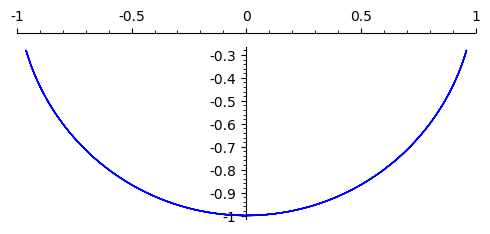

In [30]:
ode=[xd,yd,sol[0][0].rhs().subs({g:1}),sol[0][1].rhs().subs({g:1})]
times = srange(0,14,0.01)
numsol=desolve_odeint(ode,[0,-1,1.2,0],times,[x,y,xd,yd])
p=line(zip(numsol[:,0],numsol[:,1]),figsize=5,aspect_ratio=1)
p.show()

We can compare this numerical solution with small amplitude approximation. Suppose that the pendulum starts at its lowest position,   $\phi=\arctan(y/x)=-\pi/2$ with linear velocity $\dot x(0) = 0.2$. The analytical solution in that case reads:

 $$\phi = -\pi/2 + 0.2 \sin(\omega_0 t),$$

where $\omega_0=\sqrt{g/l}=1$</p>



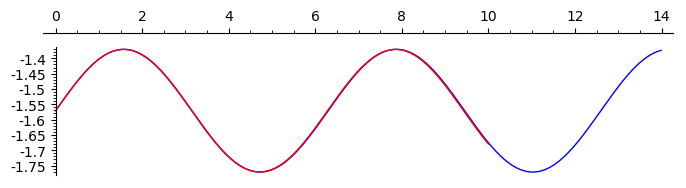

In [31]:
times = srange(0,14,0.01)
numsol = desolve_odeint(ode,[0,-1,.2,0],times,[x,y,xd,yd])

import numpy as np
 
line(zip( times,np.arctan2(numsol[:,1],numsol[:,0]) ),figsize=(7,2))+\
 plot(0.2*sin(t)-pi/2,(t,0,10),color='red')

We can also check if contraints, which are the lenght of the pendulum, are fulfilled during the simulation:

In [34]:
print "initial l:",numsol[0,0]**2+numsol[0,1]**2,
print "final l:",numsol[-1,0]**2+numsol[-1,1]**2

initial l: 1.0 final l: 0.9999999900787478


### Solution in generalized coordinaes.

Clearly, the derived system od DAE is not the best approach to describe mathematical pendulum. The better idea is to use coordinates which fulfill automatically the constraint. In the case of mathematical pendulum one can use the angle $\phi$.

We will need two sets of coordinates: $(x,y)$ and $\phi$:

In [36]:
var('x y t')
var('l g')

xy_wsp = [('x','x'),('y','y')]
uv_wsp = [('phi','\phi')]

to_fun, to_var = make_symbols(xy_wsp+uv_wsp)

x2u = {x:l*cos(phi),y:l*sin(phi)}


x  :: has been  processed
y  :: has been  processed
phi  :: has been  processed


In [37]:
uv = [vars()[v] for v,lv in uv_wsp]
xy = [vars()[v] for v,lv in xy_wsp]

We have to express virtual displacements in new coordinates:
$$\delta x =  \frac{\partial x(r,\phi)}{\partial \phi}\delta \phi $$
$$\delta y = \frac{\partial y(r,\phi)}{\partial \phi}\delta \phi $$

Despite the fact that we have only one element on `uv`, i.e. one new coordinate, we will use general formula below:

In [38]:
for w in xy:
    vars()['d'+repr(w)+'_polar']=\
       sum([w.subs(x2u).diff(w2)*vars()['d'+repr(w2)] for w2 in uv])
show([dx_polar,dy_polar])

[-dphi*l*sin(phi), dphi*l*cos(phi)]

d'Alembert principle  in new coordinates reads:


In [39]:
dAlemb = (x.subs(x2u).subs(to_fun).diff(t,2))*dx_polar + \
         (y.subs(x2u).subs(to_fun).diff(t,2)+g)*dy_polar
dAlemb = dAlemb.subs(to_var)

In [40]:
show(dAlemb)

-(l*phid^2*sin(phi) - l*phidd*cos(phi) - g)*dphi*l*cos(phi) + (l*phid^2*cos(phi) + l*phidd*sin(phi))*dphi*l*sin(phi)

Above expression is zero when coefficient at $\delta \phi$ is zero:

In [41]:
for v in uv:
    show(dAlemb.expand().coefficient(vars()['d'+repr(v)]).trig_simplify())

l^2*phidd + g*l*cos(phi)

We finally arrive at known and expected equation:

In [42]:
show( dAlemb.expand().coefficient(dphi).trig_simplify().solve(phidd) )

[phidd == -g*cos(phi)/l]

Stable point is $\phi=-\frac{\pi}{2}$, we can expand in this point the right hand side and obtain harmonic oscilator in $\phi$:

In [43]:
taylor(-g/l*cos(phi),phi,-pi/2,1).show()

-1/2*(pi + 2*phi)*g/l

one can redefine $\phi$, so it is zero at lowest point, and we recognize the classical formula:

In [44]:
taylor(-g/l*cos(phi),phi,-pi/2,1).subs({phi:phi-pi/2}).expand().show()

-g*phi/l

\newpage